# 导入依赖库及数据

In [1]:
import struct
import random
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from array import array
from os.path  import join
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import string
from tensorflow.keras.preprocessing.image import array_to_img
import imgaug as ia
import imgaug.augmenters as iaa
from keras.utils.vis_utils import plot_model


D:\Stu\CV\Z_Env\Anaconda3\envs\CV2023-QM\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Stu\CV\Z_Env\Anaconda3\envs\CV2023-QM\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Stu\CV\Z_Env\Anaconda3\envs\CV2023-QM\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [14]:
# 对Tensorflow-GPU，当GPU不可用时，运行此cell强制切换默认设备为CPU
# 这样可以直接打断cudnn调用自检过程，节省自动切换的耗时
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# 注意：这里读入的“test”为评估用测试集，训练用测试集请见后文分割出的X_val。
# 读入对应csv中的数据
X_train = pd.read_csv("sign_mnist_train.csv")
X_test = pd.read_csv("sign_mnist_test.csv")

# 读取数据集中的标签
y_train = X_train["label"]
y_test = X_test["label"]

# 将标签和数据集分离
X_train.drop(columns = ["label"], inplace = True)
X_test.drop(columns = ["label"], inplace = True)

# 打印、检查数据集和标签的数据类型
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27455, 784), (7172, 784), (27455,), (7172,))

# 数据集格式转换

In [6]:
# # 数据集图片归一化
# #X_train =X_train.astype(np.float64)/255
# X_train =X_train/255
# X_test = X_test/255


In [7]:
label = y_train.to_numpy()
label[:10]

array([ 3,  6,  2,  2, 13, 16,  8, 22,  3,  3], dtype=int64)

In [4]:
# 将数据集由点集转换为每单位28x28大小的点阵图
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

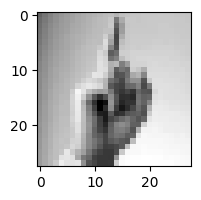

In [9]:
plt.figure(figsize = (2,2))
plt.imshow(X_train[0].reshape(28, 28) , cmap = "gray")

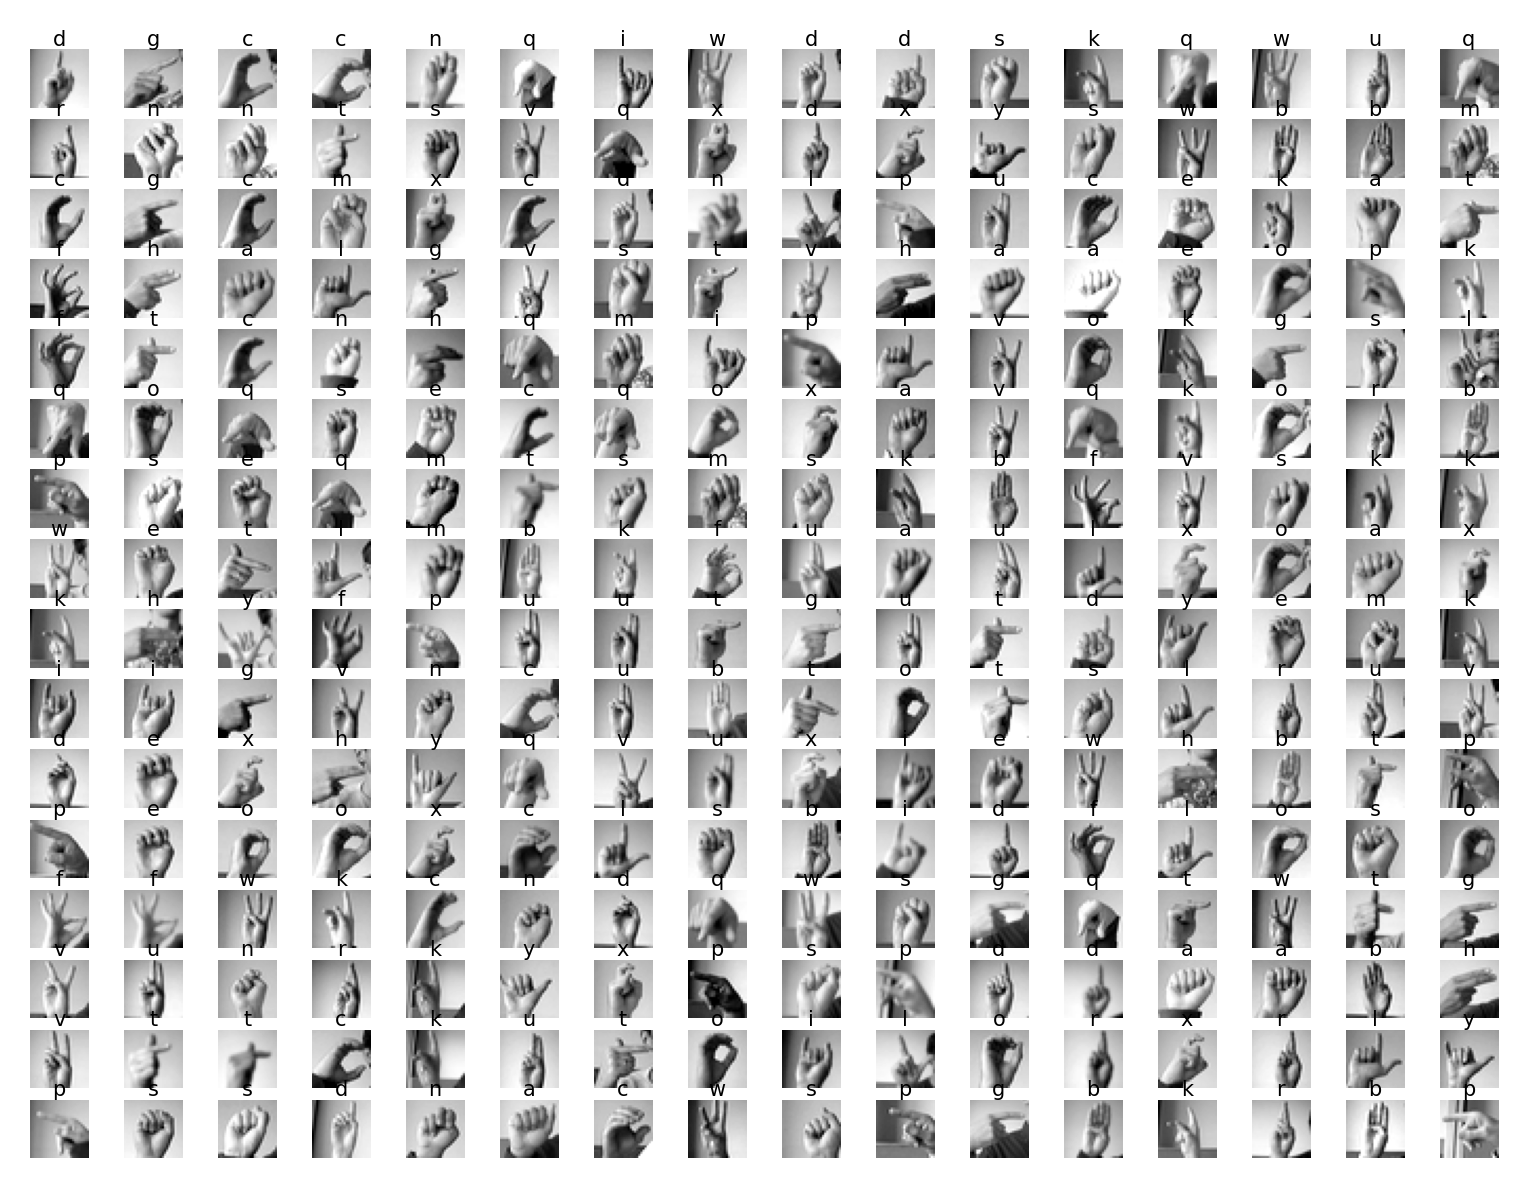

In [10]:
# 检查转型情况
data = X_train.squeeze()
label = y_train.to_numpy()
letters = list(string.ascii_lowercase)
fig = plt.figure(dpi=300)
for i in range(16):
    for j in range(16):
        plt.subplot(16,16, i*16+j+1)
        plt.imshow((data[i*16+j]),cmap='gray')
        plt.title(f"{letters[int(label[i*16+j])]}", fontdict={'size': 5}, pad=1)
        plt.axis('off')
plt.show()

# 数据增强与归一化

In [5]:
# 数据增强：使用ImgAug库的半固定比率、部分随机序列抽取增强
# 被运行时直接对整个X_train操作
imgauge=iaa.Sequential([
    #由于水平/垂直翻转将造成潜在的语义改变，故不采用
    #   随机裁剪图片边长比例的0~0.1
    iaa.Crop(percent=(0,0.1)),

    #Sometimes是指指针对20%的图片做处理
    iaa.Sometimes(
        0.2,
        #高斯模糊
        iaa.GaussianBlur(sigma=(0,0.1))
    ),

    #增强或减弱图片的对比度
    iaa.LinearContrast((0.9,1.1)),

    # 让一些图片变的更亮,一些图片变得更暗
    iaa.Multiply((0.9,1.1),per_channel=0.2),

    #仿射变换
     iaa.Sometimes(
         0.2,
        iaa.Affine(
            # 缩放填充变换，将造成可能的非预期填充，已弃用
            # scale={"x":(0.7,1.3),"y":(0.7,1.3)},
            # 平移填充变换，将造成可能的非预期填充和镜像，已弃用
            # translate_percent={"x":(-0.3,0.3),"y":(-0.3,0.3)},
            # 水平旋转，由于大角度旋转将可能改变手势的语义，故仅提供±15度的旋转范围
            rotate=(-15,15),
            # 噪声块插值
            # 图片过小，已弃用
            # 以下是指定这些新的像素点的生成方法,这种指定通过设置cval和mode两个参数来实现。参数order用来设置插值方法。
    #         order=[0, 1],
    #         cval=(0, 255),
            mode=ia.ALL
         )
     ),
    iaa.Sometimes(
        0.3,
        # 锐化
        iaa.Sharpen(alpha=(0, 0.3), lightness=(0.9, 1.1)),
    ),
    # 随机组合上述操作组进行增强
    ],random_order=True
)

X_train=imgauge(images=X_train.astype(np.uint8))

In [6]:
# 数据集图片归一化
X_train =X_train.astype(np.float64)/255
#X_train =X_train/255
X_test = X_test/255


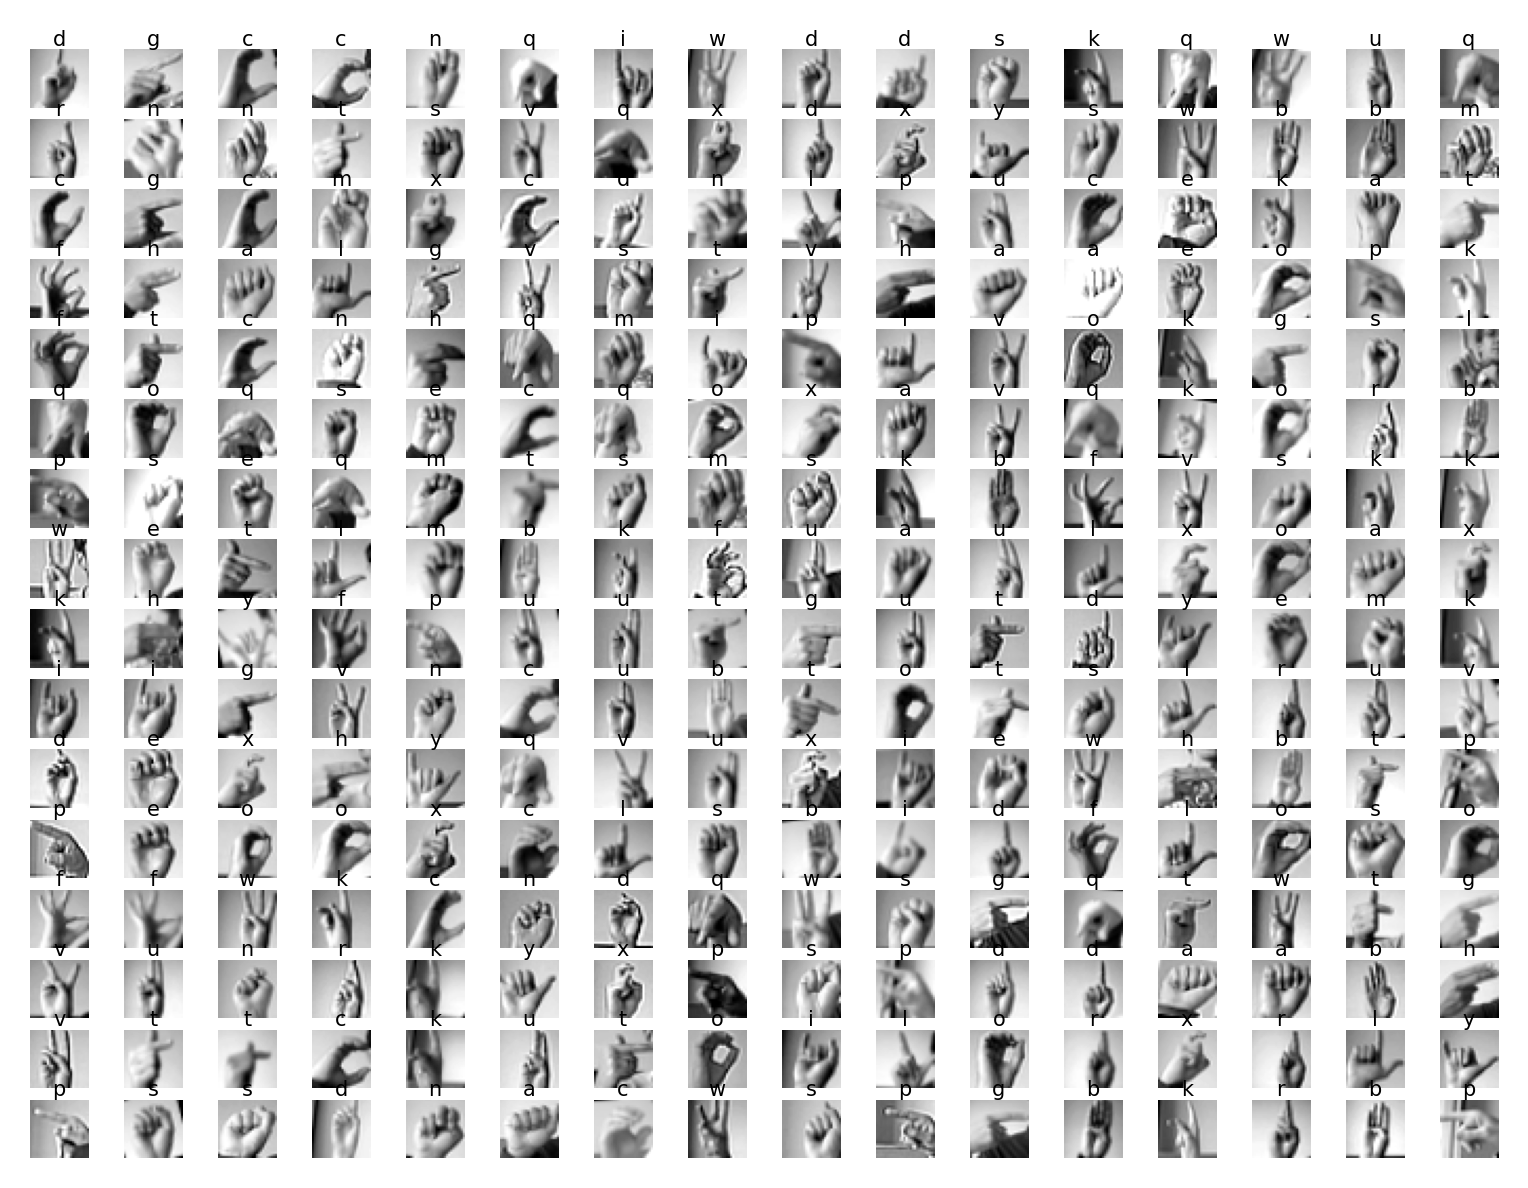

In [12]:
# 检查增强后的数据情况
data = X_train.squeeze()
label = y_train.to_numpy()
letters = list(string.ascii_lowercase)
fig = plt.figure(dpi=300)
for i in range(16):
    for j in range(16):
        plt.subplot(16,16, i*16+j+1)
        plt.imshow((data[i*16+j]),cmap='gray')
        plt.title(f"{letters[int(label[i*16+j])]}", fontdict={'size': 5}, pad=1)
        plt.axis('off')
plt.show()

In [9]:
# 增强图像数据以防止过度拟合
# 数据增强：定义ImageDataGenerator非固定比率随机抽选增强函数
# 后续被调用时才会启用
datagen = ImageDataGenerator(
        featurewise_center=False,  # 将数据集的输入平均值设置为0
        samplewise_center=False,  # 将每个样本的平均值设置为0
        featurewise_std_normalization=False,  # 将输入除以数据集的标准差
        samplewise_std_normalization=False,  # 将每个输入除以其标准差
        zca_whitening=False,  # 应用zca白化
        rotation_range=10,  # 随机旋转范围内的图像，单位度
        zoom_range = 0.1, # 随机缩放图像
        width_shift_range=0.1,  # 随机水平移动图像
        height_shift_range=0.1,  # 随机垂直移动图像
        horizontal_flip=False,  # 随机翻转图像
        vertical_flip=False)  # 随机翻转图像

datagen.fit(X_train)

In [13]:
print(y_train)

0         3
1         6
2         2
3         2
4        13
         ..
27450    13
27451    23
27452    18
27453    17
27454    23
Name: label, Length: 27455, dtype: int64


# 使用Resnet50代替CNN以改进效果

In [23]:
# 构建一般捷径恒等残差块
def identity_block(X, f, filters, training=True):
    # 定义filter
    f1,f2,f3 = filters
    X_shortcut = X 
    
    # 构建第一组
    X = tf.keras.layers.Conv2D(filters = f1, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tf.keras.layers.Activation('relu')(X)
    
    # 构建第二组
    X = tf.keras.layers.Conv2D(filters = f2, kernel_size = f, strides = (1,1), padding = 'same')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tf.keras.layers.Activation('relu')(X)
    
    # 构建第三组 
    X = tf.keras.layers.Conv2D(filters = f3, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    # 张量输入
    X = tf.keras.layers.Add()([X_shortcut,X])
    X = tf.keras.layers.Activation('relu')(X)
    
    # 返回最终结果
    return X

# 定义卷积捷径恒等残差块
def convolutional_block(X, f, filters, s=2,training=True):
    # 定义filter
    f1,f2,f3 = filters
    X_shortcut = X 
    
    # 构建第一组
    X = tf.keras.layers.Conv2D(filters = f1, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tf.keras.layers.Activation('relu')(X)
    
    # 构建第二组
    X = tf.keras.layers.Conv2D(filters = f2, kernel_size = f, strides = (s,s), padding = 'same')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tf.keras.layers.Activation('relu')(X)
    
    # 构建第三组
    X = tf.keras.layers.Conv2D(filters = f3, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    # 匹配输入量和输出量格式
    X_shortcut =tf.keras.layers.Conv2D(filters = f3, kernel_size = 1, strides = (s,s), padding = 'valid')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization(axis = 3)(X_shortcut, training = training)
    X = tf.keras.layers.Add()([X_shortcut,X])
    X = tf.keras.layers.Activation('relu')(X)
    
    # 加入张量
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    # 返回输出张量
    return X

# 定义ResNet50
def ResNet50(input_shape = (28, 28, 1), classes = 26):
    
    # 定义输入量
    X_input = tf.keras.Input(input_shape)
    
    # 定义0填充
    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    # 第一阶段
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 第二阶段
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    # 添加平均池化层
    X = tf.keras.layers.AveragePooling2D((2,2))(X)

    # 拉平、全连接组成的输出阶段
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='softmax')(X)
    
    # 创建模型
    model = tf.keras.Model(inputs = X_input, outputs = X)

    return model

In [24]:
# 初始化模型
model_res50 = ResNet50()

# 编译
model_res50.compile(optimizer="adam",metrics=["accuracy"],loss = "sparse_categorical_crossentropy")

model_res50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 30, 30, 64)   1664        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 30, 30, 64)   256         conv2d_3[0][0]                   
______________________________________________________________________________________________

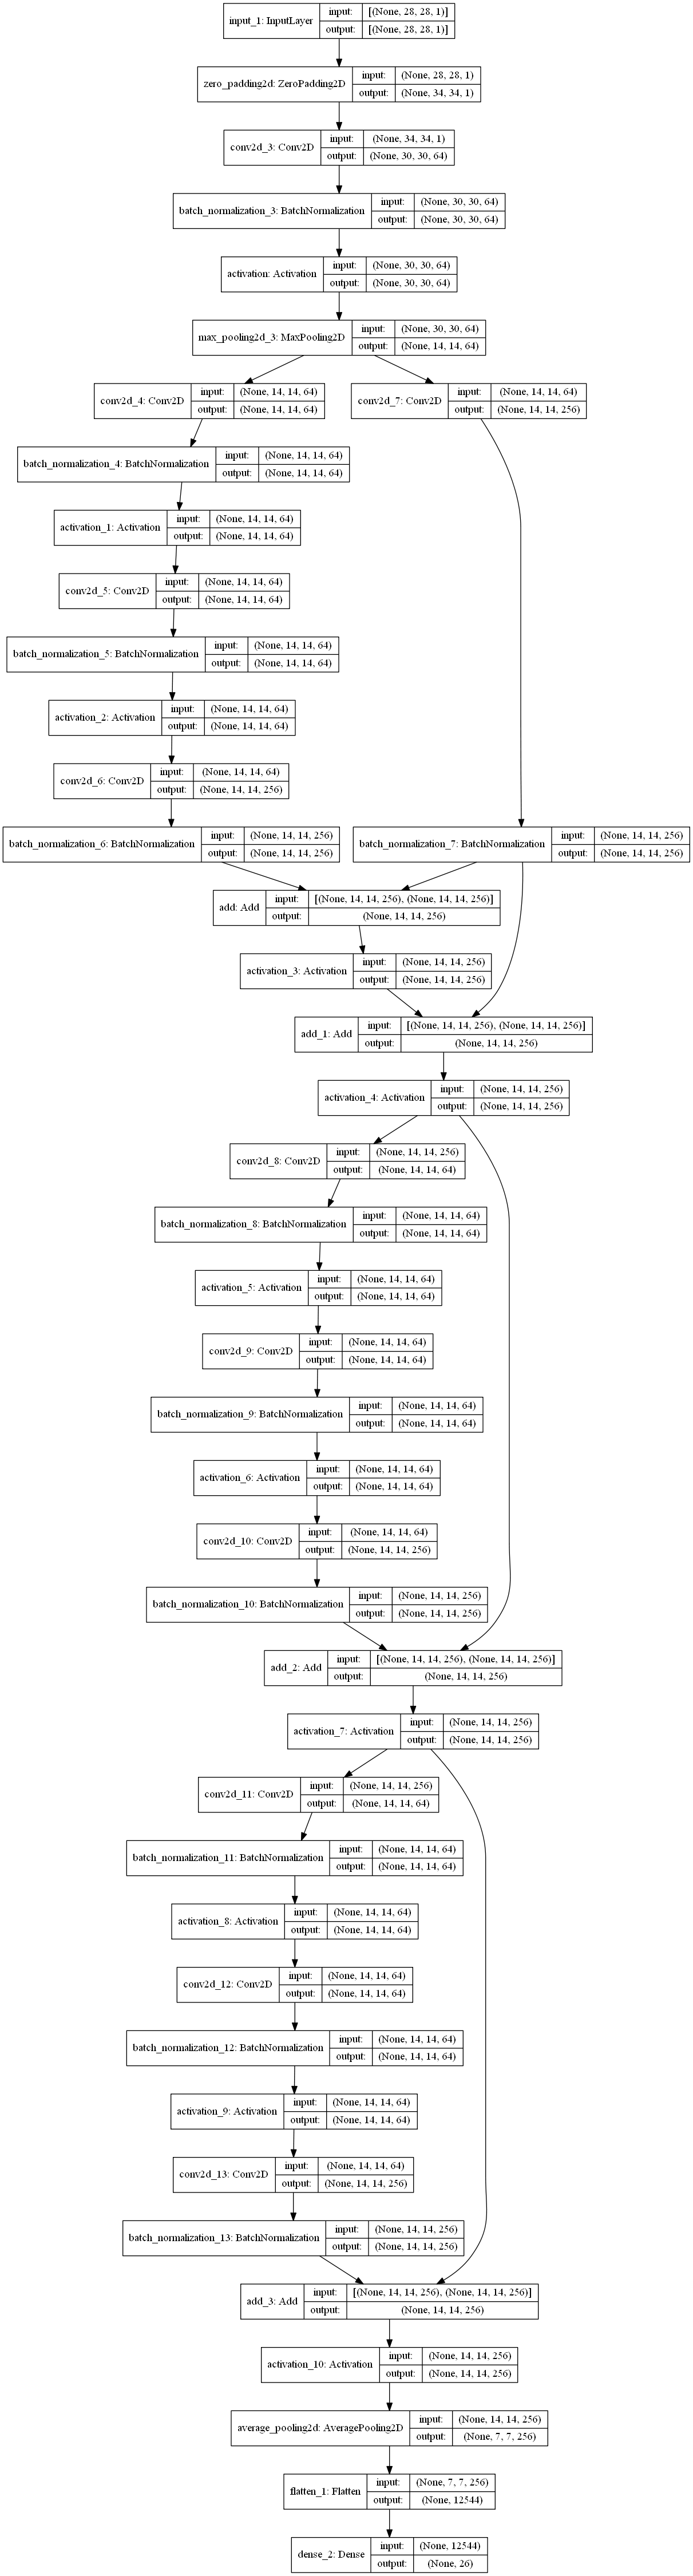

In [25]:
# 模型结构可视化
tf.keras.utils.plot_model(
    model_res50,
    to_file="model_res50.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [17]:
# 自适应学习率回调函数定义。
# 参数值定义：监测参考标准=训练用测试集损失值、等待轮次阈值=2、显示自适应调整=True(=1)、每次下降倍率=0.5（倍）、最小学习率=1e-5。
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [18]:
# 分割训练用训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [26]:
# 训练
# 入参：对入参为X_train(图片）和y_train（标签）的datagen函数进行bs=128固定大小的顺序序列读取并随机增强
# 训练bs=128、轮次=20、测试数据为分割出的训练用测试集（X_val,y_val）、回调所接入的函数为learning_rate_reduction自适应学习率函数
history1 = model_res50.fit(datagen.flow(X_train,y_train, batch_size = 128), batch_size=128,
                           validation_data = (X_val, y_val),epochs =20,
                          callbacks = [learning_rate_reduction])

Epoch 1/20
172/172 [==============================] - 8s 40ms/step - loss: 3.8011 - accuracy: 0.5387 - val_loss: 0.4268 - val_accuracy: 0.8652
Epoch 2/20
172/172 [==============================] - 6s 34ms/step - loss: 0.4275 - accuracy: 0.8623 - val_loss: 0.1280 - val_accuracy: 0.9570
Epoch 3/20
172/172 [==============================] - 6s 34ms/step - loss: 0.2207 - accuracy: 0.9290 - val_loss: 0.0743 - val_accuracy: 0.9738
Epoch 4/20
172/172 [==============================] - 6s 37ms/step - loss: 0.1327 - accuracy: 0.9570 - val_loss: 0.0208 - val_accuracy: 0.9933
Epoch 5/20
172/172 [==============================] - 6s 37ms/step - loss: 0.1095 - accuracy: 0.9664 - val_loss: 0.0183 - val_accuracy: 0.9938
Epoch 6/20
172/172 [==============================] - 7s 38ms/step - loss: 0.1187 - accuracy: 0.9649 - val_loss: 0.0823 - val_accuracy: 0.9714
Epoch 7/20
172/172 [==============================] - 7s 38ms/step - loss: 0.1259 - accuracy: 0.9643 - val_loss: 0.0604 - val_accuracy: 0.9831

## Resnet50训练结果定量评估

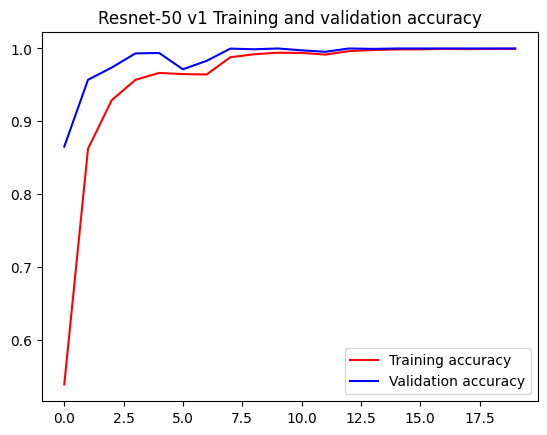

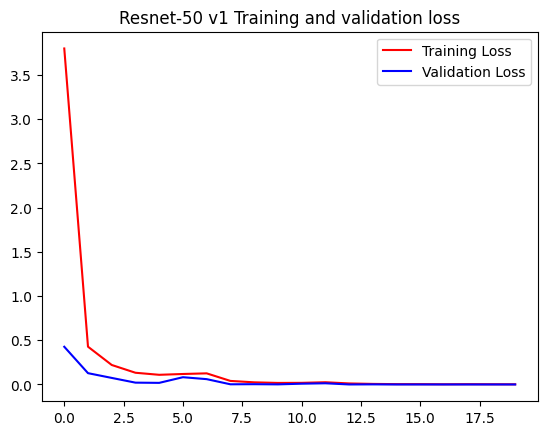

In [27]:
# 获取准确率与损失函数情况
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

# matplotlib绘制训练过程中指标的变化状况
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Resnet-50 v1 Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Resnet-50 v1 Training and validation loss')
plt.legend()

plt.show()

In [28]:
print("Test Accuracy " , model_res50.evaluate(X_test,y_test)[1]*100 , "%")

225/225 [==============================] - 2s 9ms/step - loss: 6.2155e-04 - accuracy: 1.0000
Test Accuracy  100.0 %


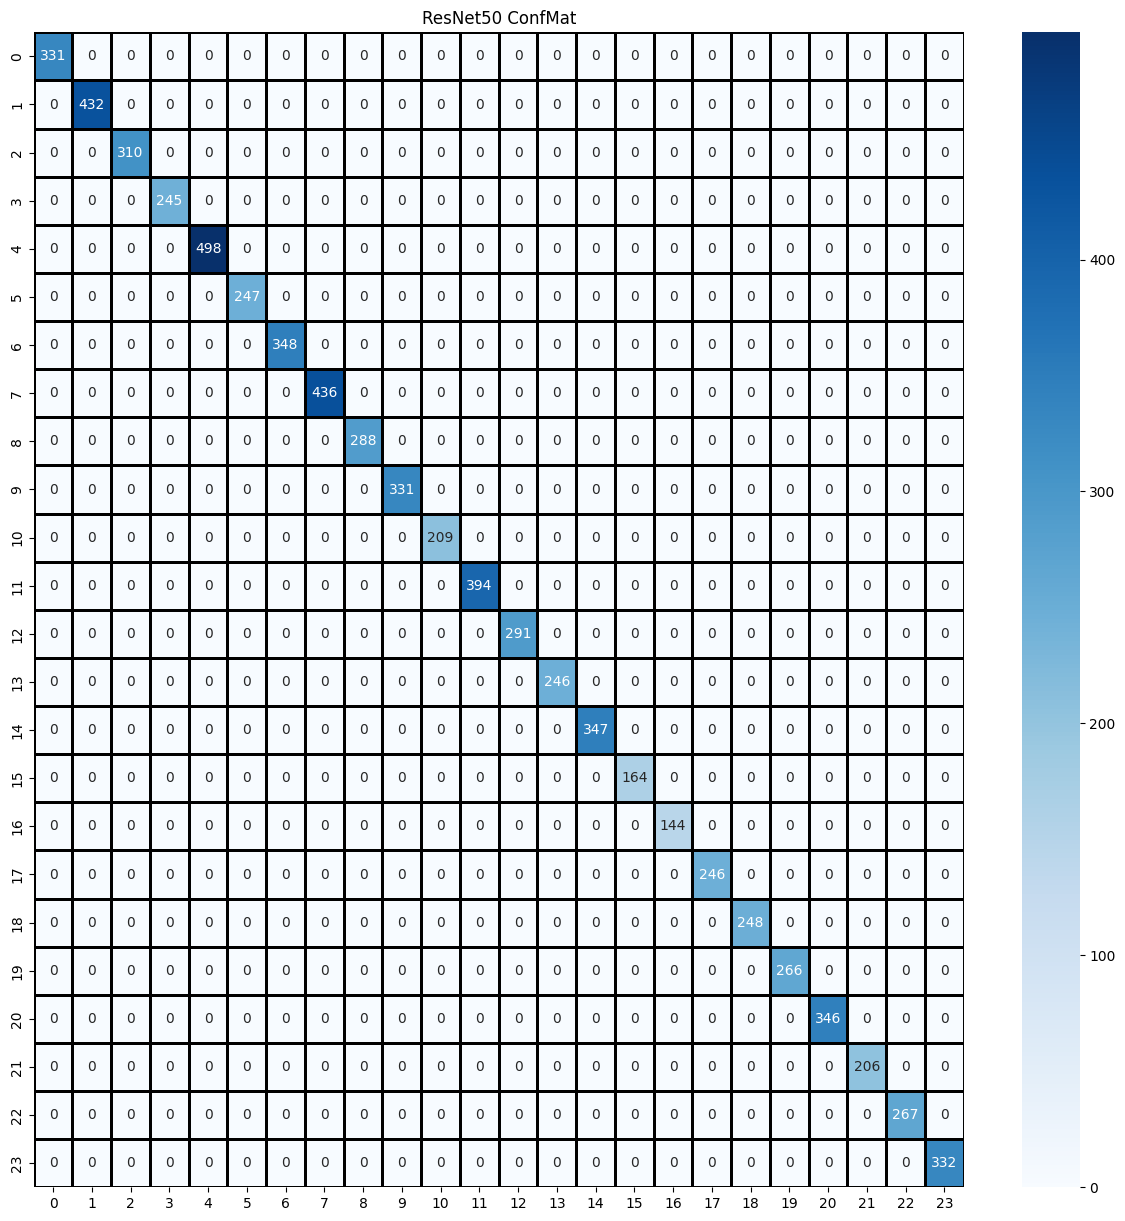

In [14]:
model_res50=tf.keras.models.load_model("1/model_res50.keras")
y_pred=model_res50.predict(X_test) 
classes_y=np.argmax(y_pred,axis=1)
dfConfMat = pd.DataFrame(confusion_matrix(y_test,classes_y))
plt.figure(figsize = (15,15))
plt.title('ResNet50 ConfMat')
sns.heatmap(dfConfMat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='');

# 对照组CNN模型的建立与训练

In [14]:
#三层卷积，两层全连接。可视化网络结构表见下一个cell。
def getCNNModel(shape):
    
    model = Sequential([
        Conv2D(64, (3,3), strides = 1, padding = "same", input_shape = shape, activation = "relu"),
        BatchNormalization(),
        MaxPool2D((2,2), strides =2, padding = "same"),
        Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        Dropout(0.2),
        BatchNormalization(),
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        BatchNormalization(),
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Flatten(),
        Dense(512 , activation = 'relu'),
        Dropout(0.3),
        Dense(units = 25 , activation = 'softmax')
    ])
    
    return model

In [15]:
# 模型编译及结构表显示
model = getCNNModel(X_train[0].shape)
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0

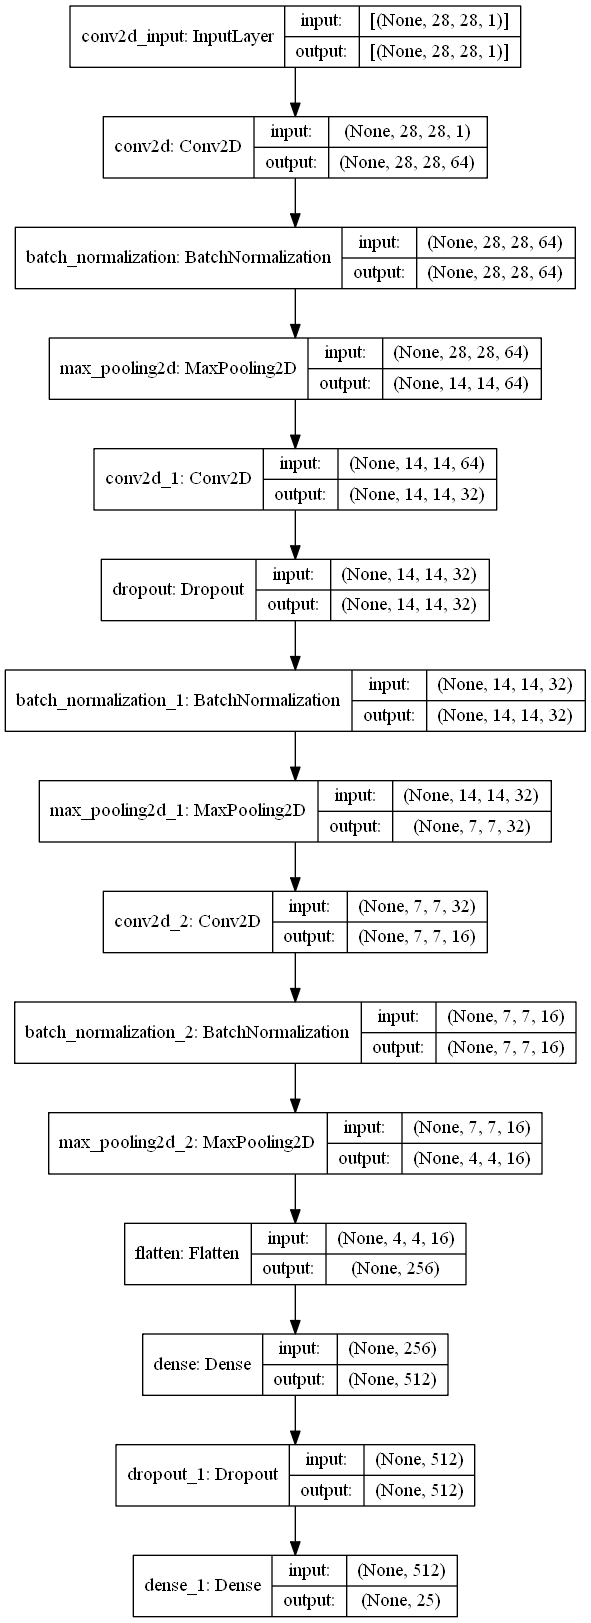

In [16]:
# 模型结构可视化
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [19]:
# 模型训练。
# 部分参数值定义：
# 入参：对入参为X_train(图片）和y_train（标签）的datagen函数进行bs=128固定大小的顺序序列读取并随机增强
# 训练bs=128、轮次=20、测试数据为分割出的训练用测试集（X_val,y_val）、回调所接入的函数为learning_rate_reduction自适应学习率函数
history = model.fit(datagen.flow(X_train,y_train, batch_size = 128) ,batch_size = 128, epochs = 20 , validation_data = (X_val, y_val) , 
                     callbacks = [learning_rate_reduction])

Epoch 1/20
172/172 [==============================] - 7s 20ms/step - loss: 1.5697 - accuracy: 0.5158 - val_loss: 4.5508 - val_accuracy: 0.0373
Epoch 2/20
172/172 [==============================] - 3s 18ms/step - loss: 0.5468 - accuracy: 0.8149 - val_loss: 3.5632 - val_accuracy: 0.1249
Epoch 3/20
172/172 [==============================] - 3s 18ms/step - loss: 0.3171 - accuracy: 0.8953 - val_loss: 0.7162 - val_accuracy: 0.7734
Epoch 4/20
172/172 [==============================] - 3s 19ms/step - loss: 0.2189 - accuracy: 0.9287 - val_loss: 0.1305 - val_accuracy: 0.9639
Epoch 5/20
172/172 [==============================] - 3s 19ms/step - loss: 0.1608 - accuracy: 0.9482 - val_loss: 0.1521 - val_accuracy: 0.9521
Epoch 6/20
172/172 [==============================] - 3s 18ms/step - loss: 0.1311 - accuracy: 0.9574 - val_loss: 0.0396 - val_accuracy: 0.9880
Epoch 7/20
172/172 [==============================] - 3s 18ms/step - loss: 0.1205 - accuracy: 0.9608 - val_loss: 0.0483 - val_accuracy: 0.9869

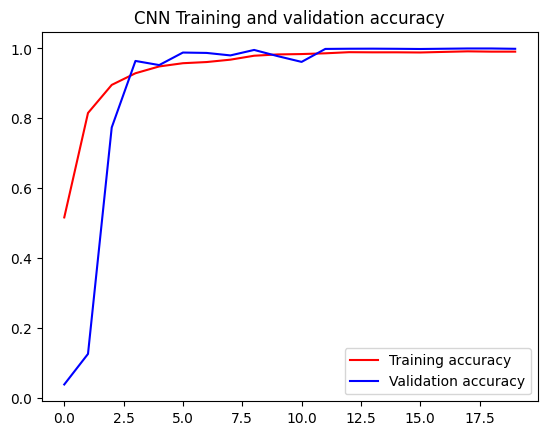

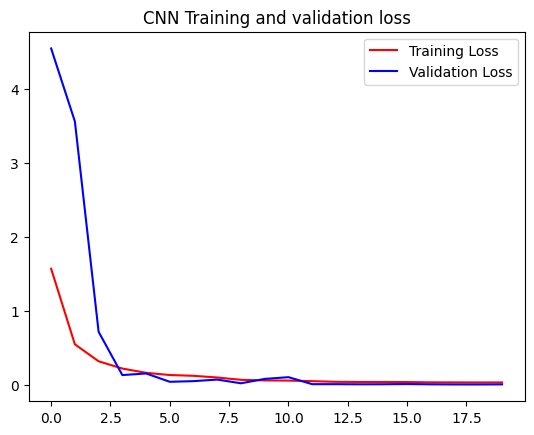

In [20]:
# 获取准确率与损失函数情况
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib绘制训练过程中指标的变化状况
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('CNN Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('CNN Training and validation loss')
plt.legend()

plt.show()

# CNN训练结果定量评估

In [21]:
# 测试用测试集对上述模型进行评估 
print("Test Accuracy " , model.evaluate(X_test,y_test)[1]*100 , "%")

225/225 [==============================] - 1s 4ms/step - loss: 0.0170 - accuracy: 0.9960
Test Accuracy  99.59564805030823 %


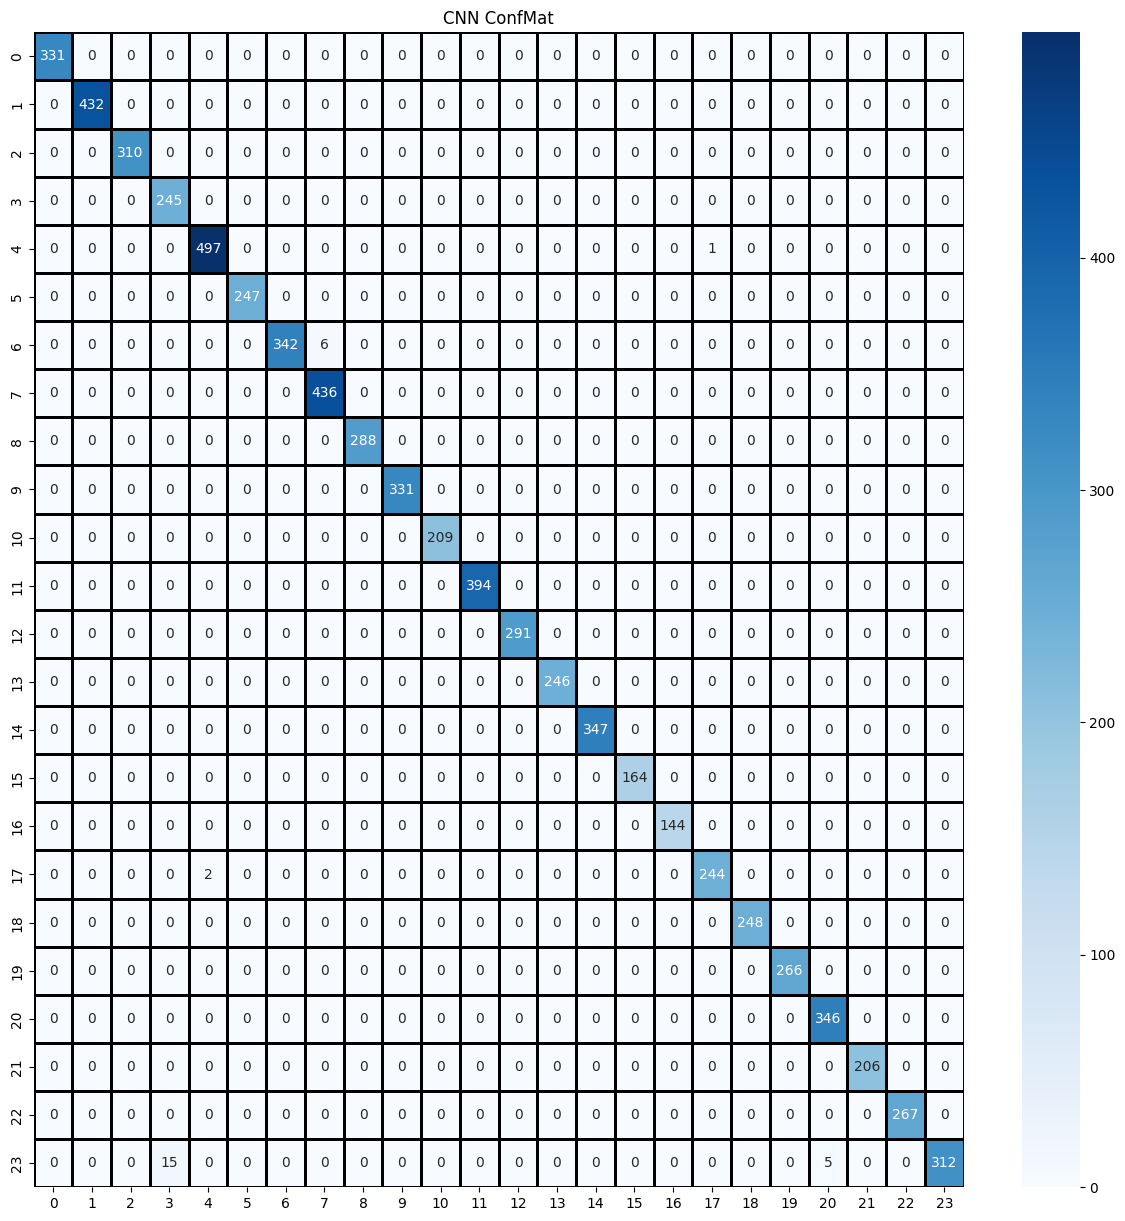

In [13]:
# 混淆矩阵可视化
model=tf.keras.models.load_model("1/model_cnn.keras")
y_pred=model.predict(X_test) 
classes_y=np.argmax(y_pred,axis=1)
dfConfMat = pd.DataFrame(confusion_matrix(y_test,classes_y))
plt.figure(figsize = (15,15))
plt.title('CNN ConfMat')
sns.heatmap(dfConfMat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='');

# 保存模型

In [30]:
model.save('models/model_cnn.keras')
model_res50.save('models/model_res50.keras')

D:\Stu\CV\Z_Env\Anaconda3\envs\CV2023-QM\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
